In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from ahrs.filters import Madgwick

In [2]:
df_altitude = pd.read_csv("./betaflight_18_04_2023/df_altitude.csv", index_col=0).dropna()[:300]
df_attitude = pd.read_csv("./betaflight_18_04_2023/df_attitude.csv", index_col=0).dropna()[:300]
df_rawIMU = pd.read_csv("./betaflight_18_04_2023/df_rawIMU.csv", index_col=0).dropna()[:300]
df_rawIMU

,ax,ay,az,gx,gy,gz,mx,my,mz,elapsed,timestamp
0,-213.0,-368.0,245.0,17.0,32.0,-27.0,0.0,0.0,0.0,0.015,1.681843e+09
1,-214.0,-370.0,246.0,8.0,6.0,-16.0,0.0,0.0,0.0,0.015,1.681843e+09
2,-213.0,-370.0,240.0,18.0,12.0,-26.0,0.0,0.0,0.0,0.016,1.681843e+09
3,-212.0,-368.0,246.0,12.0,7.0,-30.0,0.0,0.0,0.0,0.016,1.681843e+09
4,-208.0,-367.0,245.0,26.0,54.0,-20.0,0.0,0.0,0.0,0.016,1.681843e+09
...,...,...,...,...,...,...,...,...,...,...,...
329,-9.0,-71.0,495.0,913.0,-570.0,-391.0,0.0,0.0,0.0,0.016,1.681843e+09
330,0.0,6.0,488.0,1497.0,-296.0,-627.0,0.0,0.0,0.0,0.016,1.681843e+09
331,8.0,73.0,479.0,1829.0,141.0,-620.0,0.0,0.0,0.0,0.016,1.681843e+09
332,39.0,144.0,491.0,1681.0,-205.0,-527.0,0.0,0.0,0.0,0.016,1.681843e+09


In [3]:
df_altitude

,estalt,vario,elapsed,timestamp
0,-458.0,-1.0,0.016,1.681843e+09
1,-416.0,-1.0,0.015,1.681843e+09
2,-432.0,-1.0,0.015,1.681843e+09
3,-466.0,-1.0,0.015,1.681843e+09
4,-416.0,-1.0,0.015,1.681843e+09
...,...,...,...,...
319,-458.0,-1.0,0.014,1.681843e+09
320,-441.0,-1.0,0.014,1.681843e+09
321,-432.0,-1.0,0.014,1.681843e+09
322,-466.0,-1.0,0.014,1.681843e+09


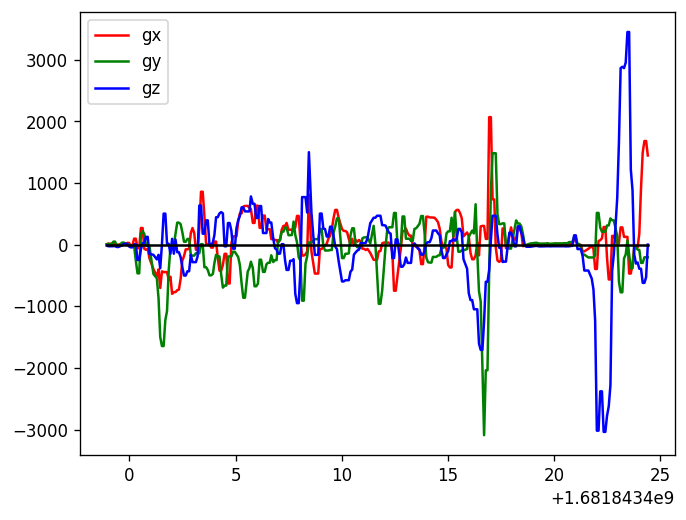

In [4]:
plt.figure(dpi=120)
# plt.plot(df_rawIMU["timestamp"], df_rawIMU["az"], color="green")
# yy = scipy.signal.medfilt(df_rawIMU["az"])
plt.plot(df_rawIMU["timestamp"], scipy.signal.medfilt(df_rawIMU["gx"]), label="gx", color="r")
plt.plot(df_rawIMU["timestamp"], scipy.signal.medfilt(df_rawIMU["gy"]), label="gy", color="g")
plt.plot(df_rawIMU["timestamp"], scipy.signal.medfilt(df_rawIMU["gz"]), label="gz", color="blue")
plt.plot(df_rawIMU["timestamp"], np.linspace(0,0, df_rawIMU.shape[0]), color="black")

# plt.plot(df_altitude["timestamp"], scipy.signal.medfilt(df_altitude["estalt"]), color="y")
plt.legend()
plt.show()

# gz is to height #

In [5]:

# gyro_data = df_attitude["angx"]
num_samples = min(df_attitude.shape[0], df_rawIMU.shape[0])
gyro_data = df_attitude[["angx", "angy", "heading"]][:num_samples]
acc_data = df_rawIMU[["gx", "gy", "gz"]][:num_samples]

In [6]:
acc_data.shape, gyro_data.shape

((300, 3), (300, 3))

In [7]:
madgwick = Madgwick(gyr=gyro_data.to_numpy(), acc=acc_data.to_numpy())

In [28]:
pd.DataFrame(madgwick.Q)

,0,1,2,3
0,0.383543,0.498764,-0.627709,0.458378
1,0.148805,-0.158896,-0.839520,0.497810
2,-0.165345,-0.731845,-0.603070,0.270870
3,-0.391048,-0.913764,-0.044145,-0.100839
4,-0.407479,-0.607374,0.538349,-0.418615
...,...,...,...,...
295,0.242765,0.334254,-0.678375,0.607575
296,-0.288917,-0.300321,-0.708922,0.569002
297,-0.621664,-0.721103,-0.265521,0.151799
298,-0.558488,-0.678642,0.333193,-0.341348


In [34]:
from scipy.spatial.transform import Rotation
rot = Rotation.from_quat(madgwick.Q)
rot_euler = rot.as_euler('xyz', degrees=True)
euler_df = pd.DataFrame(data=rot_euler, columns=['x', 'y', 'z'])
euler_df

,x,y,z
0,-52.817298,69.843055,-145.966535
1,24.626381,5.258572,-117.518090
2,99.017826,-36.576722,-173.946121
3,170.714053,8.613079,132.961923
4,-102.593882,71.305909,172.062075
...,...,...,...
295,-13.530300,47.352889,-102.257762
296,8.455181,-48.712333,-106.330006
297,166.564117,-33.302205,102.506015
298,-172.580737,56.665292,105.099049


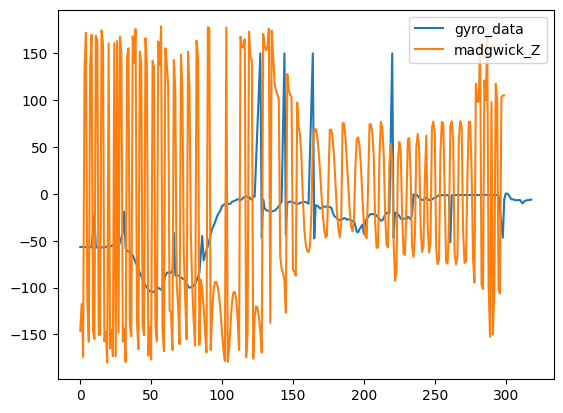

In [36]:
# gyro_data.to_numpy()
plt.plot(gyro_data["angx"], label="gyro_data")


# plt.plot(madgwick.gyr[:, 0], label="madgwick")
# plt.plot(euler_df["x"], label="madgwick_x")
# plt.plot(euler_df["y"], label="madgwick_y")
plt.plot(euler_df["z"], label="madgwick_Z")

plt.legend()
plt.show()

In [21]:
gyro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 318
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   angx     300 non-null    float64
 1   angy     300 non-null    float64
 2   heading  300 non-null    float64
dtypes: float64(3)
memory usage: 9.4 KB


In [23]:
# np.ndarray(gyro_data)
gyro_data.to_numpy()

array([[-5.660e+01,  2.530e+01,  1.750e+02],
       [-5.660e+01,  2.530e+01,  1.750e+02],
       [-5.660e+01,  2.530e+01,  1.750e+02],
       [-5.670e+01,  2.530e+01,  1.750e+02],
       [-5.670e+01,  2.530e+01,  1.750e+02],
       [-5.660e+01,  2.530e+01,  1.750e+02],
       [-5.670e+01,  2.550e+01,  1.760e+02],
       [-5.690e+01,  2.540e+01,  1.760e+02],
       [-5.700e+01,  2.520e+01,  1.760e+02],
       [-2.100e+01, -3.670e+01,  2.410e+02],
       [-5.710e+01,  2.510e+01,  1.760e+02],
       [-5.710e+01,  2.510e+01,  1.760e+02],
       [-5.700e+01,  2.510e+01,  1.760e+02],
       [-5.690e+01,  2.520e+01,  1.760e+02],
       [-5.700e+01,  2.520e+01,  1.760e+02],
       [-5.710e+01,  2.510e+01,  1.760e+02],
       [-5.700e+01,  2.490e+01,  1.760e+02],
       [-5.670e+01,  2.560e+01,  1.770e+02],
       [-5.570e+01,  2.580e+01,  1.760e+02],
       [-5.520e+01,  2.190e+01,  1.740e+02],
       [-5.630e+01,  2.530e+01,  1.760e+02],
       [-5.520e+01,  2.550e+01,  1.770e+02],
       [-5

In [16]:
# gyr=gyro_data, acc=acc_data
Q = np.tile([1., 0., 0., 0.], (num_samples, 1)) # Allocate for quaternions
for t in range(1, num_samples):
    Q[t] = madgwick.updateIMU(Q[t-1], gyr=gyro_data[t], acc=acc_data[t])

KeyError: 1

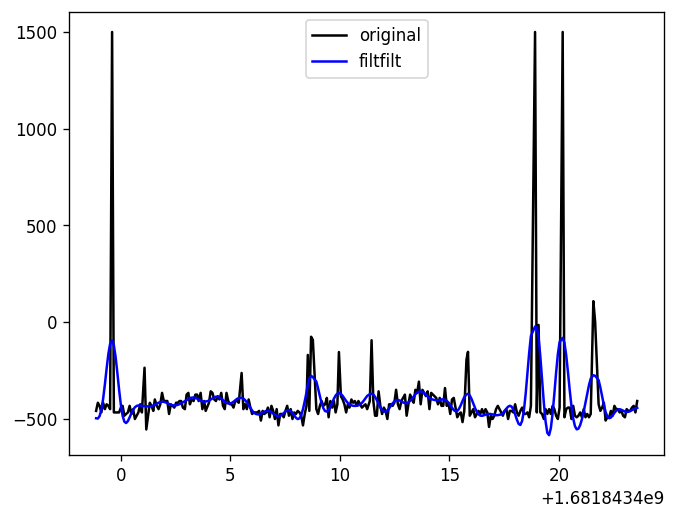

In [112]:
plt.figure(dpi=120)

# plt.plot(df_altitude["timestamp"], df_altitude["estalt"], color="red")
# plt.plot(df_altitude["timestamp"], scipy.signal.wiener(df_altitude["estalt"], (5)), label="wiener", color="blue")
plt.plot(df_altitude["timestamp"], df_altitude["estalt"], label="original", color="black")
# plt.plot(df_altitude["timestamp"], scipy.signal.medfilt(df_altitude["estalt"]), label="medfilt", color="y")

b, a = scipy.signal.butter(3, 0.05)
zi = scipy.signal.lfilter_zi(b, a)
# plt.plot(df_altitude["timestamp"], scipy.signal.lfilter(b, a, df_altitude["estalt"], zi=zi*df_altitude["estalt"][0])[0], label="lfilter", color="red")
# plt.plot(df_altitude["timestamp"], scipy.signal.savgol_filter(df_altitude["estalt"], 30, 3), label="savgol_filter", color="blue")

# plt.plot(df_altitude["timestamp"], scipy.signal.lfilter(b, a, df_altitude["estalt"], zi=-zi*500)[0], label="lfilter2", color="green")
# plt.plot(df_altitude["timestamp"], scipy.signal.medfilt(df_altitude["estalt"]), label="medfi/lt", color="y")

b, a = scipy.signal.ellip(4, 0.01, 120, 0.125) 
plt.plot(df_altitude["timestamp"], scipy.signal.filtfilt(b, a, df_altitude["estalt"], method="gust"), label="filtfilt", color="blue")
# plt.plot(df_altitude["timestamp"], scipy.signal.filtfilt(b, a, df_altitude["estalt"], padlen=50), label="filtfilt", color="red")

plt.legend()
plt.show()


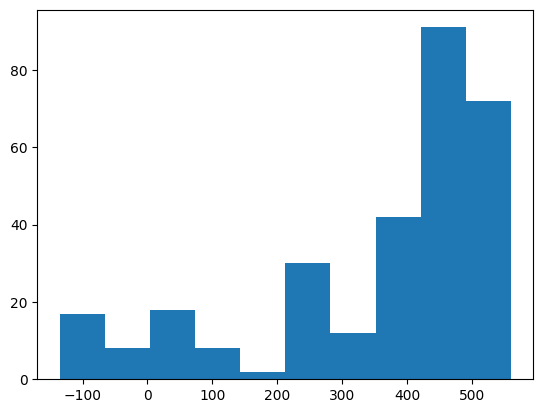

In [43]:
# df_rawIMU.info()
yy = scipy.signal.medfilt(df_rawIMU["az"])
plt.hist(yy)
plt.show()

In [53]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [54]:
np.arange(25).reshape(5, 5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])